In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft 
from scipy import signal
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

In [2]:
# what are we doing? we are trying to get the heart rate (HR) and resipiratory rate (RR)
# how are we going to do this?
# using two techniques, SCG and BCG, that need
# info about the mechanical properties of the human body such as acceleration, angular velocity

# first things first, we load the center_sternum dataset and add a time column as index

df=pd.read_csv("center_sternum.txt",sep=None,engine='python')
df['time_s'] = np.arange(0,df.shape[0])/200 # let's construct the time axis, with each sampling separated by a 200th of a second (because sampling rate is 200 Hz)
df=df.set_index('time_s')
df

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
time_s,,,,,,,,,,,,,,,,
0.000,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
0.005,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
0.010,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
0.015,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
0.020,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82.505,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
82.510,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
82.515,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502


In [3]:
#drop some columns 

new_df=df.drop(columns=['Log Mode','Log Freq','Timestamp','qw','qi','qj','qk'])

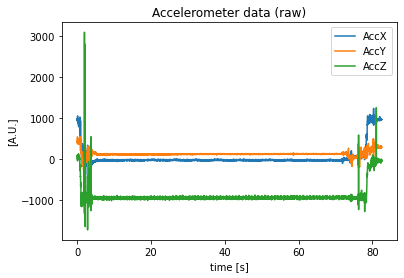

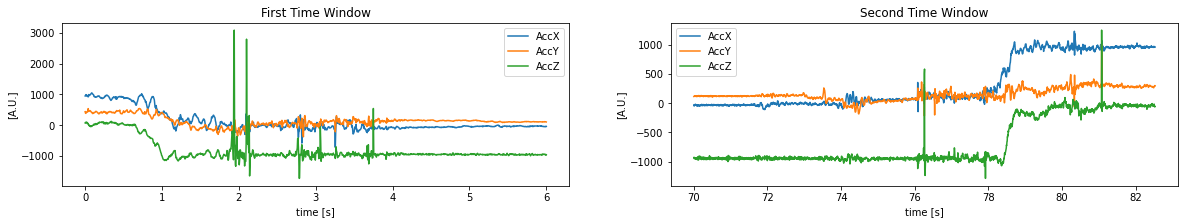

In [4]:
# now let's look at the acceleration vector by plotting its three components

new_df.plot(y=['AccX','AccY','AccZ'], title= 'Accelerometer data (raw)',ylabel='[A.U.]', xlabel='time [s]')

figure, axes = plt.subplots(1, 2, figsize=(20,3))
new_df.loc[0:6].plot(ax=axes[0],y=['AccX','AccY','AccZ'],title='First Time Window',ylabel='[A.U.]', xlabel='time [s]')
new_df.loc[70:].plot(ax=axes[1],y=['AccX','AccY','AccZ'],title='Second Time Window',ylabel='[A.U.]', xlabel='time [s]');

In [5]:
#clean up the data (we select a time intervall from 6s to 71s)

data=new_df.loc[6:71].copy()

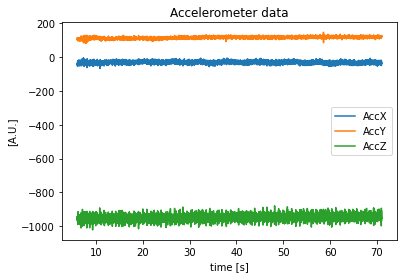

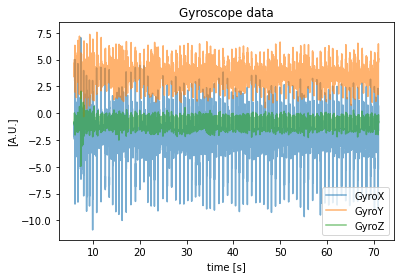

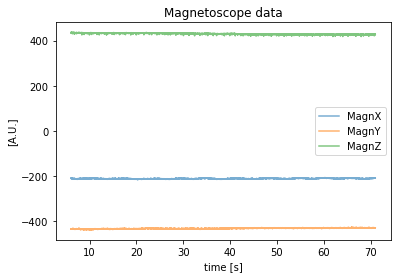

In [6]:

data.plot(y=['AccX','AccY','AccZ'],title= 'Accelerometer data',ylabel='[A.U.]', xlabel='time [s]')


data.plot(y=['GyroX','GyroY','GyroZ'],title= 'Gyroscope data',alpha=0.6,ylabel='[A.U.]', xlabel='time [s]')


data.plot(y=['MagnX','MagnY','MagnZ'],title= 'Magnetoscope data',alpha=0.6,ylabel='[A.U.]', xlabel='time [s]');

In [7]:
#normalize dataset

#data=(data-data.mean())/data.std()
data=(data-data.mean())
data.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04
mean,2.880865e-14,-4.190240e-14,-2.513361e-12,2.436069e-15,3.848933e-15,-3.862485e-15,-3.794662e-14,2.702303e-13,2.593609e-13
std,7.105334e+00,5.720993e+00,1.463913e+01,1.461396e+00,7.408600e-01,3.951268e-01,1.328302e+00,1.973405e+00,3.039088e+00
min,-3.609259e+01,-3.304326e+01,-7.291116e+01,-8.800674e+00,-4.009284e+00,-4.080810e+00,-4.405046e+00,-6.625875e+00,-1.195770e+01
25%,-4.616589e+00,-3.519256e+00,-8.861159e+00,-6.174639e-01,-4.214974e-01,-2.487491e-01,-4.050458e-01,-1.625875e+00,-2.957696e+00
50%,8.041058e-02,2.627443e-01,-3.821591e-01,-6.784586e-02,-5.508543e-02,1.079311e-02,-4.050458e-01,3.741251e-01,4.230444e-02
75%,4.716411e+00,3.800744e+00,8.035841e+00,6.344441e-01,3.265936e-01,2.550679e-01,5.949542e-01,1.374125e+00,3.042304e+00
max,2.692041e+01,3.210474e+01,6.970684e+01,9.138261e+00,3.868579e+00,2.926824e+00,4.594954e+00,5.374125e+00,7.042304e+00


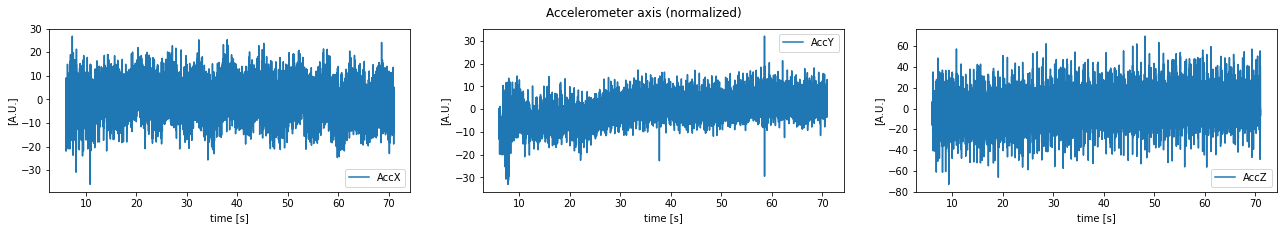

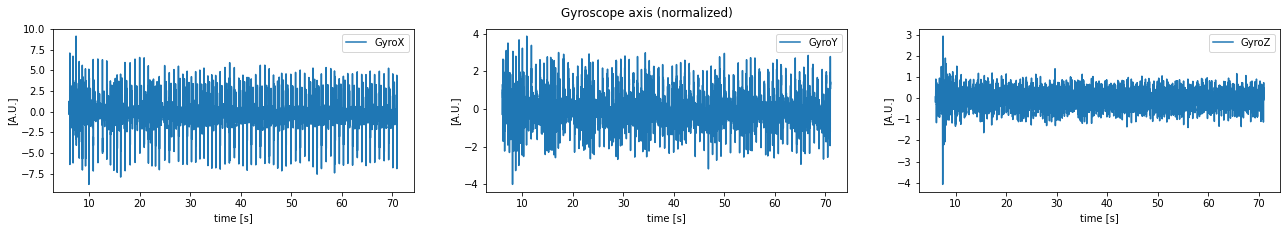

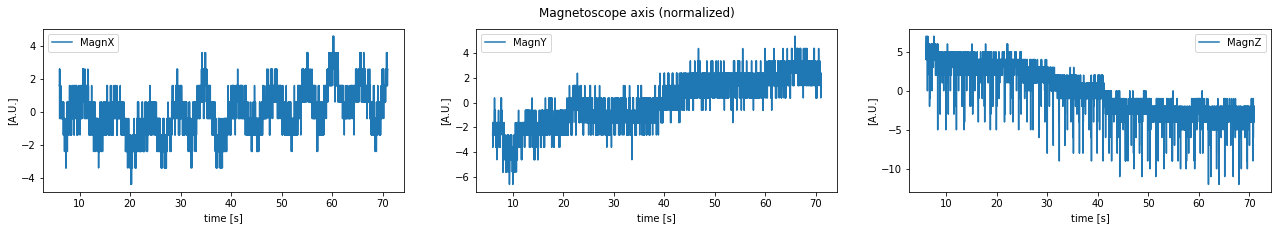

In [8]:
#accelerometer plots

figure, axes = plt.subplots(1, 3, figsize=(22,3))
figure.suptitle('Accelerometer axis (normalized)')
data.plot(ax=axes[0],y=['AccX'], ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[1],y=['AccY'],ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[2],y=['AccZ'], ylabel='[A.U.]', xlabel='time [s]')


#gyroscope plots

figure, axes = plt.subplots(1, 3, figsize=(22,3))
figure.suptitle('Gyroscope axis (normalized)')
data.plot(ax=axes[0],y=['GyroX'], ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[1],y=['GyroY'],ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[2],y=['GyroZ'], ylabel='[A.U.]', xlabel='time [s]')


#magnetoscope plots

figure, axes = plt.subplots(1, 3, figsize=(22,3))
figure.suptitle('Magnetoscope axis (normalized)')
data.plot(ax=axes[0],y=['MagnX'], ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[1],y=['MagnY'],ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[2],y=['MagnZ'], ylabel='[A.U.]', xlabel='time [s]');

 Accelerometer PCA:
Percentage of variance due to the selected component: 75.92%

 Gyroscope PCA:
Percentage of variance due to the selected component: 79.96%

 Magnetoscope PCA:
Percentage of variance due to the selected component: 81.08%

 Total PCA:
Percentage of variance due to the selected component: 71.95%


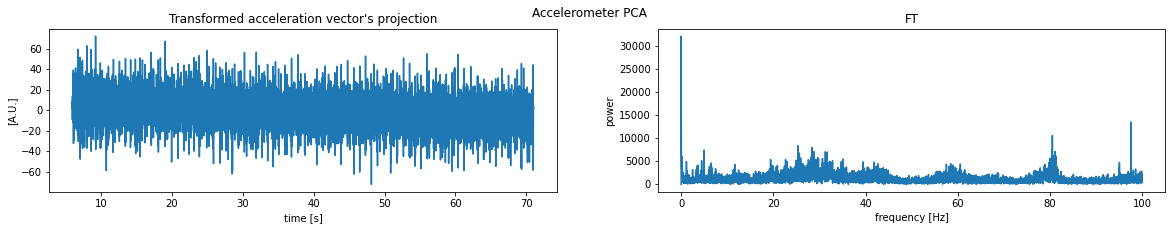

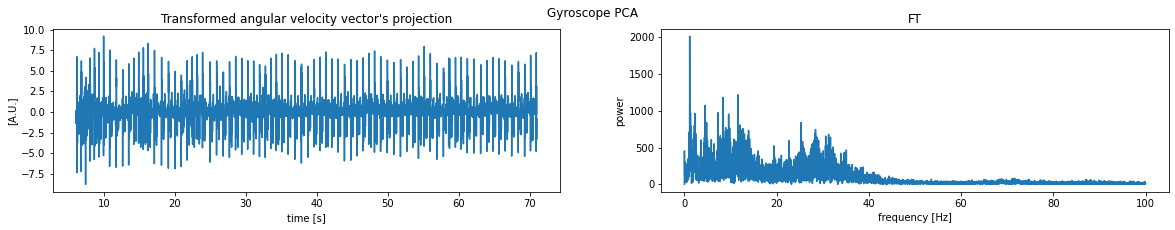

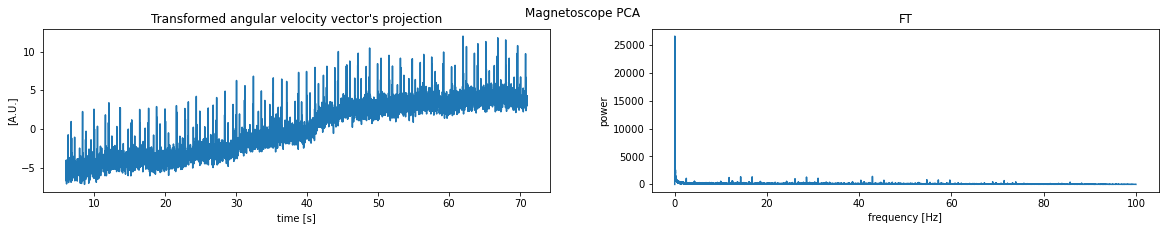

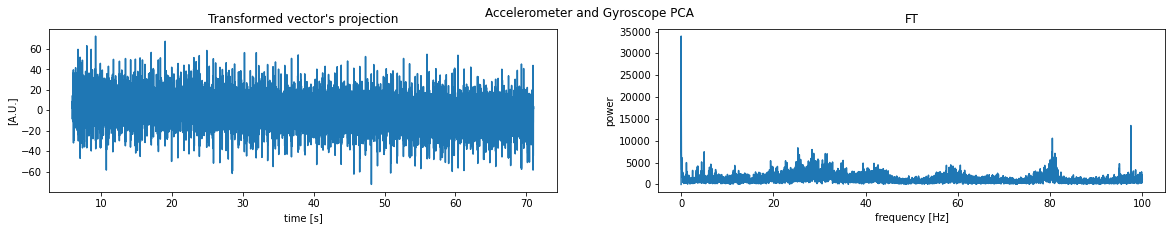

In [9]:
#performing PCA

acc_columns = ['AccX','AccY','AccZ']
gyro_columns= ['GyroX','GyroY','GyroZ']
magn_columns=['MagnX','MagnY','MagnZ']
total_columns = acc_columns + gyro_columns + magn_columns

sampling_rate = 200 
sample_spacing = 1/sampling_rate

pca=PCA(n_components=1) # we seek a single signal

print(' Accelerometer PCA:')

pca.fit(data[acc_columns])
print("Percentage of variance due to the selected component: {:.2%}".format(pca.explained_variance_ratio_[0]))
accT=pca.transform(data[acc_columns]).reshape(-1)

accT_FT=fft.fft(accT)
accT_FT_freq=fft.fftfreq(accT.size,sample_spacing)
N = int(accT_FT_freq.size/2) #ignoring negative frequencies since input is real valued
accT_freq_pos = accT_FT_freq[:N]
accT_FT_pos = np.abs(accT_FT[:N])

with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    fig.suptitle('Accelerometer PCA')
    axs[0].plot(data.index,accT)
    axs[0].set_title("Transformed acceleration vector's projection")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(accT_FT_freq[:N],np.abs(accT_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power')
    
    
print('\n Gyroscope PCA:')

pca.fit(data[gyro_columns])
print("Percentage of variance due to the selected component: {:.2%}".format(pca.explained_variance_ratio_[0]))
gyrT=pca.transform(data[gyro_columns]).reshape(-1)


gyrT_FT=fft.fft(gyrT)
gyrT_FT_freq=fft.fftfreq(accT.size,sample_spacing)
N = int(gyrT_FT_freq.size/2) 
gyrT_freq_pos = gyrT_FT_freq[:N]
gyrT_FT_pos = np.abs(gyrT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    fig.suptitle('Gyroscope PCA')
    axs[0].plot(data.index,gyrT)
    axs[0].set_title("Transformed angular velocity vector's projection")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(gyrT_FT_freq[:N],np.abs(gyrT_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power')

    
print('\n Magnetoscope PCA:')

pca.fit(data[magn_columns])
print("Percentage of variance due to the selected component: {:.2%}".format(pca.explained_variance_ratio_[0]))
magT=pca.transform(data[magn_columns]).reshape(-1)


magT_FT=fft.fft(magT)
magT_FT_freq=fft.fftfreq(magT.size,sample_spacing)
N = int(magT_FT_freq.size/2) 
magT_freq_pos = magT_FT_freq[:N]
magT_FT_pos = np.abs(gyrT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    fig.suptitle('Magnetoscope PCA')
    axs[0].plot(data.index,magT)
    axs[0].set_title("Transformed angular velocity vector's projection")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(magT_FT_freq[:N],np.abs(magT_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power')


In [10]:
#usefoul function for further analysis

def f(x,a,b,c,d):
    return a*np.exp(-pow(x-b,2)/(2*pow(c,2)))+d


In [11]:
#let's see if the selected componet drifts

drift_acc=np.polyfit(data.index,accT,1)
drift_gyro=np.polyfit(data.index,gyrT,1)
drift_mag=np.polyfit(data.index,magT,1)
drift_total=np.polyfit(data.index,totalT,1)

print(drift_acc)
print(drift_gyro)
print(drift_mag)
print(drift_total)

acc_clean=accT-(drift_acc[0]*data.index + drift_acc[1])
gyr_clean=gyrT-(drift_gyro[0]*data.index + drift_gyro[1])
mag_clean=magT-(drift_mag[0]*data.index + drift_mag[1])

[-0.23093169  8.89086997]
[ 0.00353522 -0.13610603]
[ 0.17156286 -6.60517009]
[-0.24213787  9.32230787]


In [12]:
#Butter filter settings (2Hz)

order=10 #order of the filter
trashold=2 #cut-off freq

sos = signal.butter(order, trashold, 'lp', fs=sampling_rate, output='sos')

# of points to perform fit: 37
Fit parametres for HR:
 [ 3.24135573e+03  1.18096569e+00  2.74925206e-01 -1.33001634e+03] 

Heart rate estimated: 70.85794139094135 +/- 16.4955123380905 bpm
Percentage of error: 23.279694575207248 %


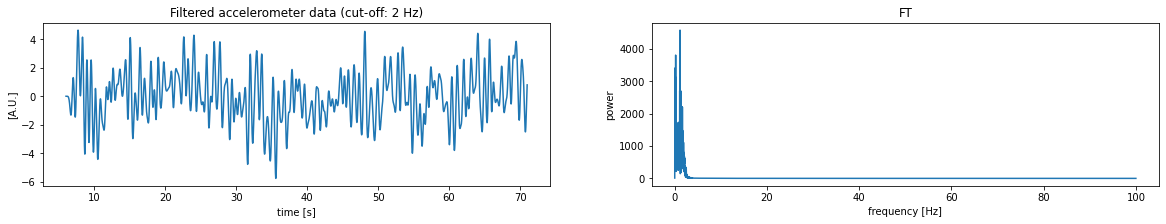

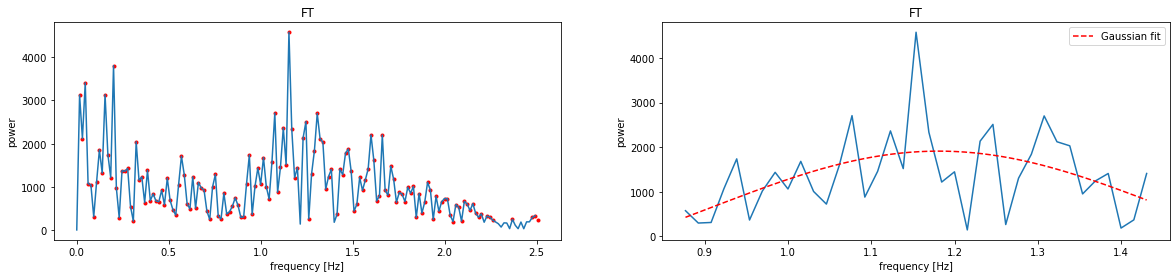

In [13]:
#let's try to denoising the selected PCA component of the accelerometer via low-pass Butter filter in order to
#see the heart rate


filt_acc = signal.sosfilt(sos, acc_clean)

filt_acc_FT=fft.fft(filt_acc)
filt_acc_FT_freq=fft.fftfreq(filt_acc.size,sample_spacing)
N = int(filt_acc_FT_freq.size/2) 
filt_acc_freq_pos = accT_FT_freq[:N]
filt_acc_FT_pos = np.abs(accT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,filt_acc)
    axs[0].set_title("Filtered accelerometer data (cut-off: 2 Hz)")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(filt_acc_FT_freq[:N],np.abs(filt_acc_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');

#let's zoom the FT

x=filt_acc_FT_freq[:N]
y=np.abs(filt_acc_FT[:N])

zoom=np.where(x<2.5)
power_trashold=200

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])

#Heart rate estimation

cardiac=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[cardiac], y[cardiac]) 
x_range=np.linspace(x[cardiac].min(),x[cardiac].max(),1000) 

fig,ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[cardiac],y[cardiac])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('# of points to perform fit:',len(x[cardiac]))
print('Fit parametres for HR:\n', popt, '\n')
print('Heart rate estimated:', 60*popt[1], '+/-', popt[2]*60, 'bpm' )
print('Percentage of error:', err_perc, '%')

# of points to perform fit: 37
Fit parametres for HR:
 [1.56722927e+03 1.15461467e+00 1.14737626e-02 3.67291407e+02] 

Heart rate estimated: 69.27687997924448 +/- 0.6884257577372042 bpm
Percentage of error: 0.9937308925336391 %


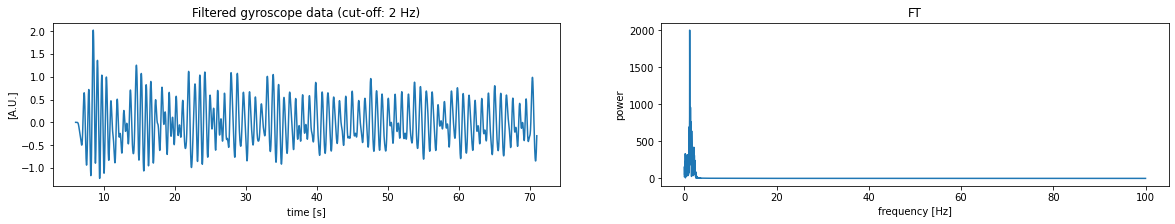

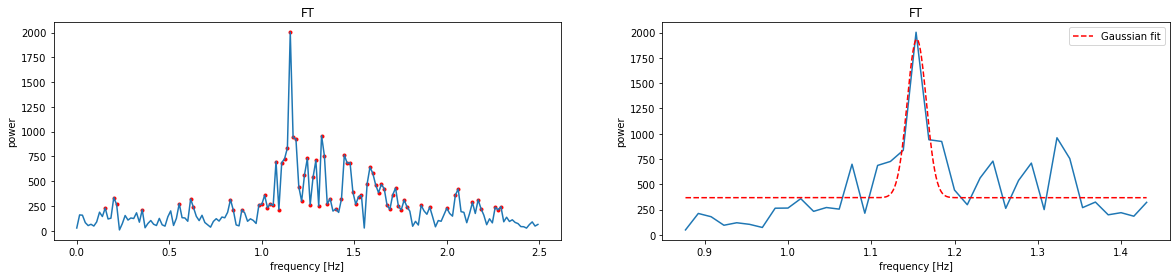

In [14]:
#let's try to denoising the selected PCA component of the gyroscope via low-pass Butter filter in order to
#see the heart rate


filt_gyro = signal.sosfilt(sos, gyr_clean)

filt_gyro_FT=fft.fft(filt_gyro)
filt_gyro_FT_freq=fft.fftfreq(filt_gyro.size,sample_spacing)
N = int(filt_gyro_FT_freq.size/2) 
filt_gyro_freq_pos = gyrT_FT_freq[:N]
filt_gyro_FT_pos = np.abs(gyrT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,filt_gyro)
    axs[0].set_title("Filtered gyroscope data (cut-off: 2 Hz)")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(filt_gyro_FT_freq[:N],np.abs(filt_gyro_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');

#let's zoom the FT

x=filt_gyro_FT_freq[:N]
y=np.abs(filt_gyro_FT[:N])

zoom=np.where(x<2.5)
power_trashold=200

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])

#Heart rate estimation

cardiac=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[cardiac], y[cardiac]) 
x_range=np.linspace(x[cardiac].min(),x[cardiac].max(),1000) 

fig,ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[cardiac],y[cardiac])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('# of points to perform fit:',len(x[cardiac]))
print('Fit parametres for HR:\n', popt, '\n')
print('Heart rate estimated:', 60*popt[1], '+/-', popt[2]*60, 'bpm' )
print('Percentage of error:', err_perc, '%')

# of points to perform fit: 21
Fit parametres for HR:
 [2.04417705e+04 2.31811817e-02 4.01980296e-03 6.34819922e+02] 

Heart rate estimated: 1.390870904416898 +/- 0.2411881773297274 bpm
Percentage of error: 17.34080255498924 %


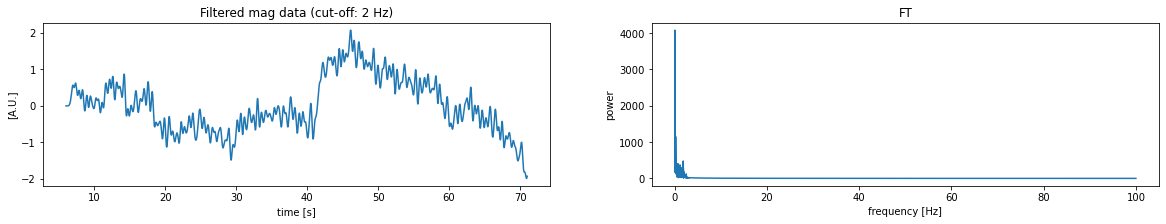

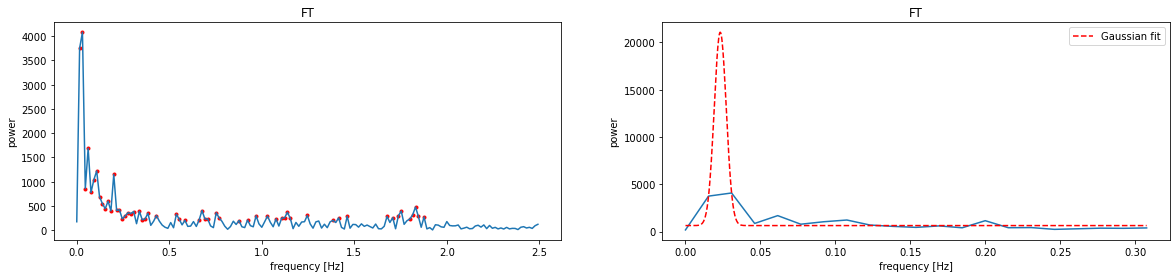

In [15]:
#let's try to denoising the selected PCA component of the magelerometer and gyroscope via low-pass Butter filter in order to
#see the heart rate


filt_mag = signal.sosfilt(sos, mag_clean)

filt_mag_FT=fft.fft(filt_mag)
filt_mag_FT_freq=fft.fftfreq(filt_mag.size,sample_spacing)
N = int(filt_mag_FT_freq.size/2) 
filt_mag_freq_pos = magT_FT_freq[:N]
filt_mag_FT_pos = np.abs(magT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,filt_mag)
    axs[0].set_title("Filtered mag data (cut-off: 2 Hz)")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(filt_mag_FT_freq[:N],np.abs(filt_mag_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');

#let's zoom the FT

x=filt_mag_FT_freq[:N]
y=np.abs(filt_mag_FT[:N])

zoom=np.where(x<2.5)
power_trashold=200

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])

#Heart rate estimation

cardiac=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[cardiac], y[cardiac]) 
x_range=np.linspace(x[cardiac].min(),x[cardiac].max(),1000) 

fig,ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[cardiac],y[cardiac])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('# of points to perform fit:',len(x[cardiac]))
print('Fit parametres for HR:\n', popt, '\n')
print('Heart rate estimated:', 60*popt[1], '+/-', popt[2]*60, 'bpm' )
print('Percentage of error:', err_perc, '%')

# of points to perform fit: 37
Fit parametres for HR:
 [ 3.03040448e+03  1.18124002e+00  2.62771029e-01 -1.11632069e+03] 

Heart rate estimated: 70.87440131792657 +/- 15.76626174969888 bpm
Percentage of error: 22.245354396681233 %


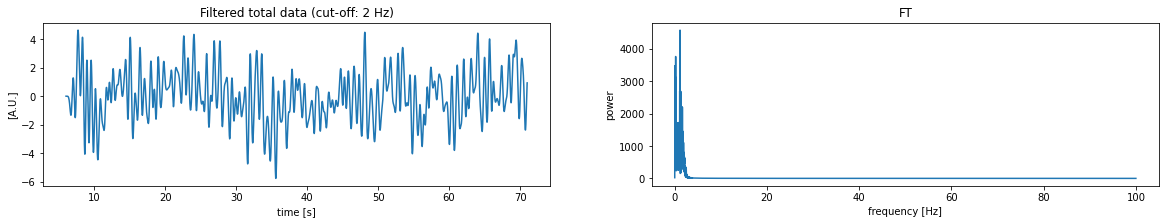

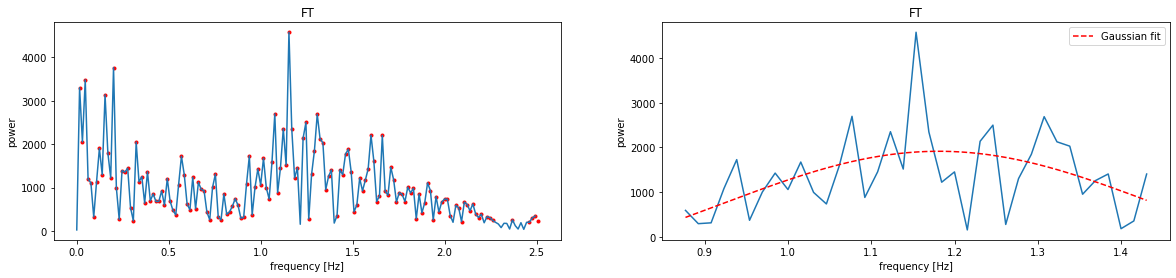

In [16]:
#let's try to denoising the selected PCA component of the totalelerometer and gyroscope via low-pass Butter filter in order to
#see the heart rate


filt_total = signal.sosfilt(sos, total_clean)

filt_total_FT=fft.fft(filt_total)
filt_total_FT_freq=fft.fftfreq(filt_total.size,sample_spacing)
N = int(filt_total_FT_freq.size/2) 
filt_total_freq_pos = totalT_FT_freq[:N]
filt_total_FT_pos = np.abs(totalT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,filt_total)
    axs[0].set_title("Filtered total data (cut-off: 2 Hz)")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(filt_total_FT_freq[:N],np.abs(filt_total_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');

#let's zoom the FT

x=filt_total_FT_freq[:N]
y=np.abs(filt_total_FT[:N])

zoom=np.where(x<2.5)
power_trashold=200

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])

#Heart rate estimation

cardiac=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[cardiac], y[cardiac]) 
x_range=np.linspace(x[cardiac].min(),x[cardiac].max(),1000) 

fig,ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[cardiac],y[cardiac])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('# of points to perform fit:',len(x[cardiac]))
print('Fit parametres for HR:\n', popt, '\n')
print('Heart rate estimated:', 60*popt[1], '+/-', popt[2]*60, 'bpm' )
print('Percentage of error:', err_perc, '%')

In [17]:
#butterfilter parameters (0.5Hz)

order=10 #order of the filter
trashold=0.5 #cut-off freq

sos = signal.butter(order, trashold, 'lp', fs=sampling_rate, output='sos')

# of points to perform fit: 32
Fit parametres for BR:
 [8.50664410e+02 8.16661757e-02 1.39842884e-01 8.59847712e+02] 

Breath rate estimated: 4.899970539656946 +/- 8.390573057843401 bpm
Percentage of error: 171.23721438600393 %


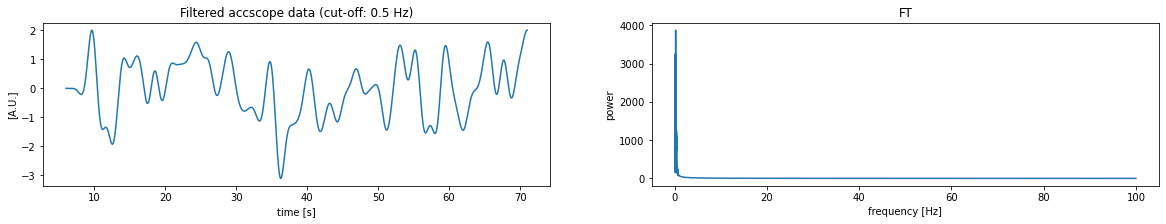

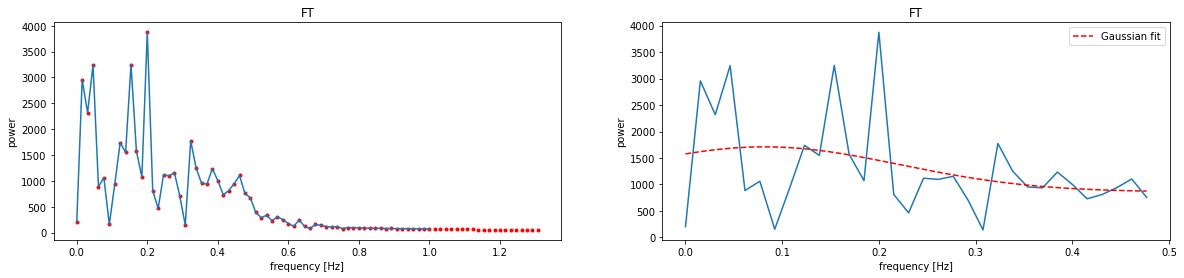

In [18]:
#let's try to denoising the selected PCA component of the accelerometer via low-pass Butter filter in order to
#see the breath rate


filt_acc = signal.sosfilt(sos, acc_clean)

filt_acc_FT=fft.fft(filt_acc)
filt_acc_FT_freq=fft.fftfreq(filt_acc.size,sample_spacing)
N = int(filt_acc_FT_freq.size/2) 
filt_acc_freq_pos = gyrT_FT_freq[:N]
filt_acc_FT_pos = np.abs(gyrT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,filt_acc)
    axs[0].set_title("Filtered accscope data (cut-off: 0.5 Hz)")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(filt_acc_FT_freq[:N],np.abs(filt_acc_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');

    
x=filt_acc_FT_freq[:N]
y=np.abs(filt_acc_FT[:N])

zoom=np.where(x<1)
power_trashold=50

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])


#breath rate estimation

breath=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[breath], y[breath]) 
x_range=np.linspace(x[breath].min(),x[breath].max(),1000) 


fig,ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[breath],y[breath])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('# of points to perform fit:',len(x[breath]))
print('Fit parametres for BR:\n', popt, '\n')
print('Breath rate estimated:', 60*popt[1], '+/-', abs(popt[2]*60), 'bpm' )
print('Percentage of error:', err_perc, '%')

# of points to perform fit: 32
Fit parametres for BR:
 [1.02047611e+02 1.87286189e-01 3.54723853e-02 9.68413921e+01] 

Breath rate estimated: 11.237171321521265 +/- 2.1283431152946806 bpm
Percentage of error: 18.940203494259354 %


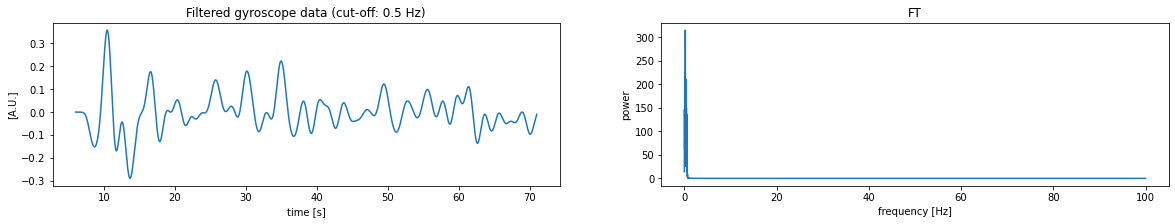

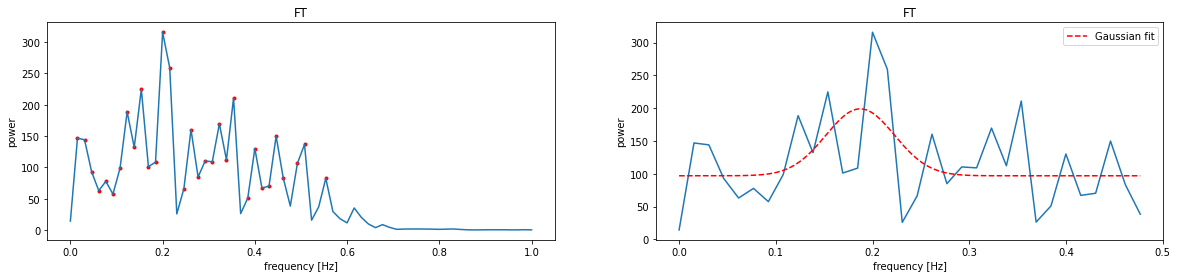

In [19]:
#let's try to denoising the selected PCA component of the gyroscope via low-pass Butter filter in order to
#see the breath rate



filt_gyro = signal.sosfilt(sos, gyr_clean)

filt_gyro_FT=fft.fft(filt_gyro)
filt_gyro_FT_freq=fft.fftfreq(filt_gyro.size,sample_spacing)
N = int(filt_gyro_FT_freq.size/2) 
filt_gyro_freq_pos = gyrT_FT_freq[:N]
filt_gyro_FT_pos = np.abs(gyrT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,filt_gyro)
    axs[0].set_title("Filtered gyroscope data (cut-off: 0.5 Hz)")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(filt_gyro_FT_freq[:N],np.abs(filt_gyro_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');

    
x=filt_gyro_FT_freq[:N]
y=np.abs(filt_gyro_FT[:N])

zoom=np.where(x<1)
power_trashold=50

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])


#breath rate estimation

breath=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[breath], y[breath]) 
x_range=np.linspace(x[breath].min(),x[breath].max(),1000) 


fig,ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[breath],y[breath])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('# of points to perform fit:',len(x[breath]))
print('Fit parametres for BR:\n', popt, '\n')
print('Breath rate estimated:', 60*popt[1], '+/-', abs(popt[2]*60), 'bpm' )
print('Percentage of error:', err_perc, '%')

# of points to perform fit: 21
Fit parametres for HR:
 [4.41446688e+03 2.38032617e-02 9.96212714e-03 5.22245070e+02] 

Heart rate estimated: 1.4281957038382205 +/- 0.5977276282087274 bpm
Percentage of error: 41.851941341257195 %


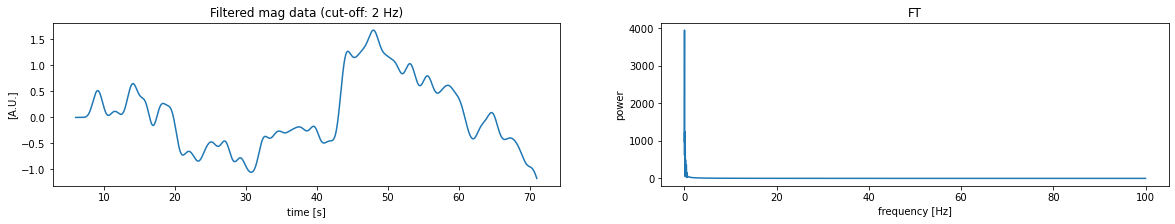

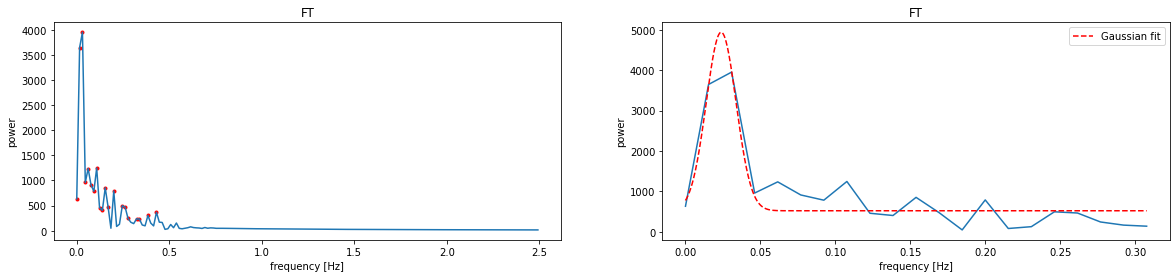

In [20]:
#let's try to denoising the selected PCA component of the magelerometer and gyroscope via low-pass Butter filter in order to
#see the heart rate


filt_mag = signal.sosfilt(sos, mag_clean)

filt_mag_FT=fft.fft(filt_mag)
filt_mag_FT_freq=fft.fftfreq(filt_mag.size,sample_spacing)
N = int(filt_mag_FT_freq.size/2) 
filt_mag_freq_pos = magT_FT_freq[:N]
filt_mag_FT_pos = np.abs(magT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,filt_mag)
    axs[0].set_title("Filtered mag data (cut-off: 2 Hz)")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(filt_mag_FT_freq[:N],np.abs(filt_mag_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');

#let's zoom the FT

x=filt_mag_FT_freq[:N]
y=np.abs(filt_mag_FT[:N])

zoom=np.where(x<2.5)
power_trashold=200

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])

#Heart rate estimation

cardiac=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[cardiac], y[cardiac]) 
x_range=np.linspace(x[cardiac].min(),x[cardiac].max(),1000) 

fig,ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[cardiac],y[cardiac])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('# of points to perform fit:',len(x[cardiac]))
print('Fit parametres for HR:\n', popt, '\n')
print('Heart rate estimated:', 60*popt[1], '+/-', popt[2]*60, 'bpm' )
print('Percentage of error:', err_perc, '%')

# of points to perform fit: 32
Fit parametres for HR:
 [8.88697337e+02 6.75449983e-02 1.48734048e-01 8.52468745e+02] 

Heart rate estimated: 4.052699898998293 +/- 8.924042886919953 bpm
Percentage of error: 220.19994347782105 %


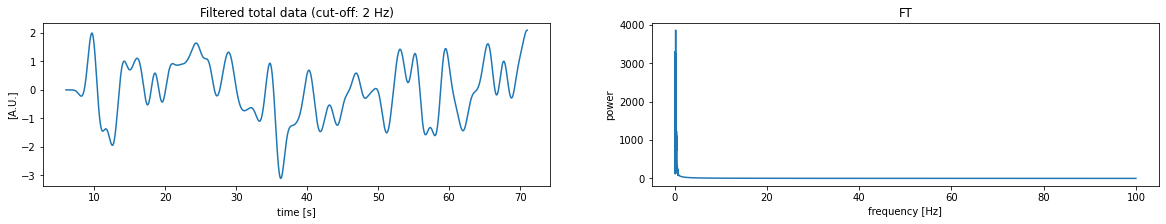

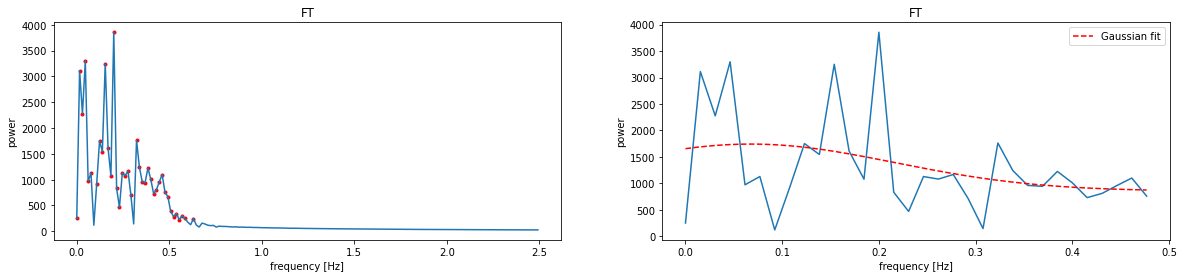

In [21]:
#let's try to denoising the selected PCA component of the totalelerometer and gyroscope via low-pass Butter filter in order to
#see the heart rate


filt_total = signal.sosfilt(sos, total_clean)

filt_total_FT=fft.fft(filt_total)
filt_total_FT_freq=fft.fftfreq(filt_total.size,sample_spacing)
N = int(filt_total_FT_freq.size/2) 
filt_total_freq_pos = totalT_FT_freq[:N]
filt_total_FT_pos = np.abs(totalT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,filt_total)
    axs[0].set_title("Filtered total data (cut-off: 2 Hz)")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(filt_total_FT_freq[:N],np.abs(filt_total_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');

#let's zoom the FT

x=filt_total_FT_freq[:N]
y=np.abs(filt_total_FT[:N])

zoom=np.where(x<2.5)
power_trashold=200

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])

#Heart rate estimation

cardiac=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[cardiac], y[cardiac]) 
x_range=np.linspace(x[cardiac].min(),x[cardiac].max(),1000) 

fig,ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[cardiac],y[cardiac])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('# of points to perform fit:',len(x[cardiac]))
print('Fit parametres for HR:\n', popt, '\n')
print('Heart rate estimated:', 60*popt[1], '+/-', popt[2]*60, 'bpm' )
print('Percentage of error:', err_perc, '%')
